In [5]:
!pip install yfinance 

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import pandas_datareader.data as pdr 
import datetime 
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import yfinance as yf

# 네이버 주식 불러오기

- 야후 파이낸스 사이트에서 데이터를 불러들이기 위해 yfinance library 사용
- 2020.1.1 부터 현재 시점까지의 네이버 주식 정보를 naver 라는 데이터프레임으로 저장

In [69]:
yf.pdr_override() 

start= (2020, 1, 1)
start= datetime.datetime(*start)
end = datetime.date.today()
naver = pdr.get_data_yahoo('035420.KS', start, end)
naver.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,187500.0,188000.0,182000.0,182500.0,182238.906250,300640
2020-01-03,185000.0,186000.0,180500.0,181500.0,181240.343750,454492
2020-01-06,180000.0,182000.0,178000.0,180500.0,180241.765625,287970
2020-01-07,182500.0,187000.0,181500.0,187000.0,186732.468750,328624
2020-01-08,182000.0,183500.0,179000.0,183000.0,182738.187500,820867


In [70]:
naver.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-12,418500.0,421500.0,413000.0,418500.0,418500.0,475697
2021-07-13,421000.0,442000.0,419000.0,441000.0,441000.0,1498546
2021-07-14,436000.0,444500.0,436000.0,444000.0,444000.0,931990
2021-07-15,446500.0,452500.0,439500.0,449000.0,449000.0,950460
2021-07-16,448000.0,461000.0,443000.0,447000.0,447000.0,1246425


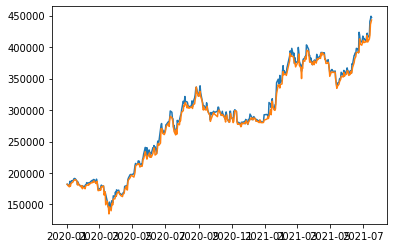

In [71]:
plt.plot(naver.index, naver['Adj Close'], naver['Low'])

# 데이터 전처리 
- target label 분리 :  y='Adj Close'
- 학습/검증 데이터 분리 
- 데이터 정규화
- 데이터 타입 변환 (ndarray -> tensor)

In [88]:
naver_copy = naver.copy()
naver_copy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,187500.0,188000.0,182000.0,182500.0,182238.906250,300640
2020-01-03,185000.0,186000.0,180500.0,181500.0,181240.343750,454492
2020-01-06,180000.0,182000.0,178000.0,180500.0,180241.765625,287970
2020-01-07,182500.0,187000.0,181500.0,187000.0,186732.468750,328624
2020-01-08,182000.0,183500.0,179000.0,183000.0,182738.187500,820867
...,...,...,...,...,...,...
2021-07-12,418500.0,421500.0,413000.0,418500.0,418500.000000,475697
2021-07-13,421000.0,442000.0,419000.0,441000.0,441000.000000,1498546
2021-07-14,436000.0,444500.0,436000.0,444000.0,444000.000000,931990


In [89]:
naver_copy[308:] #308번째부터 21년도 2분기 데이터임을 알 수 있음

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-01,375500.0,379000.0,372000.0,378500.0,378500.0,547402
2021-04-02,381500.0,382500.0,378000.0,379500.0,379500.0,476668
2021-04-05,379500.0,380000.0,374500.0,377000.0,377000.0,421508
2021-04-06,378500.0,391000.0,378000.0,388500.0,388500.0,997518
2021-04-07,390500.0,391000.0,381500.0,384500.0,384500.0,578490
...,...,...,...,...,...,...
2021-07-12,418500.0,421500.0,413000.0,418500.0,418500.0,475697
2021-07-13,421000.0,442000.0,419000.0,441000.0,441000.0,1498546
2021-07-14,436000.0,444500.0,436000.0,444000.0,444000.0,931990


In [90]:
# 2021년 1분기 데이터까지 train으로, 나머지를 test 데이터로 설정
y = naver_copy['Adj Close'] # y가 series로 할당되어 있어서 데이터 프레임으로 바꿔주었음
y = pd.DataFrame(y)
naver_copy= naver_copy.drop('Adj Close', axis = 1)
split_num = 308
x_train = naver_copy[:split_num]
x_test = naver_copy[split_num:]
y_train = y[:split_num]
y_test =y[split_num:]

In [91]:
# 정규화 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

# x는 표준화로 스케일링, 이 때 train 데이터로만 모수를 설정해야 정보 누출 문제 방지 가능 
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

# y는 minmax 정규화로 스케일링
y_train = mm.fit_transform(y_train)
y_test = mm.transform(y_test)

print('train shape x:{}, y:{}'.format(x_train.shape, y_train.shape))
print('test shape x:{}, y:{}'.format(x_test.shape, y_test.shape))

train shape x:(308, 5), y:(308, 1)
test shape x:(75, 5), y:(75, 1)


In [92]:
#torch model 에서 학습을 진행할 수 있도록 텐서로 바꿔줘야 함 

x_train = Variable(torch.Tensor(x_train))
x_test = Variable(torch.Tensor(x_test))

y_train = Variable(torch.Tensor(y_train))
y_test = Variable(torch.Tensor(y_test))

x_train = torch.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = torch.reshape(x_test,(x_test.shape[0], 1, x_test.shape[1]))

print('train shape x:{}, y:{}'.format(x_train.shape, y_train.shape))
print('test shape x:{}, y:{}'.format(x_test.shape, y_test.shape))

train shape x:torch.Size([308, 1, 5]), y:torch.Size([308, 1])
test shape x:torch.Size([75, 1, 5]), y:torch.Size([75, 1])


In [93]:
#gpu mode 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# LSTM 모델 설계
- 1 of lstm layer, 2 of fc hidden layer, 1 of output layer
- 직전 30일 정보로 1일치를 예측하는 기본적인 모델 (seq_length 를 설정할 수 있음)
- loss function : mse, optimizer: adam
- L2 Regularization

In [94]:
from torchsummary import summary

In [95]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.flatten = nn.Flatten()
    self.num_classes= num_classes
    self.input_size= input_size
    self.hidden_size=hidden_size
    self.num_layers = num_layers
    self.seq_length= seq_length

    self.lstm = nn.LSTM(input_size= input_size, hidden_size = hidden_size, 
                        num_layers= num_layers, batch_first= True)
    self.hidden_layer1= nn.Linear(hidden_size, 128)
    self.hidden_layer2= nn.Linear(128, 128)
    self.fc= nn.Linear(128, num_classes)
    self.relu =nn.ReLU()

  def forward(self, input):
    h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(device)
    c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size)).to(device)

    _ , (h, c) = self.lstm(input, (h0, c0))
    h = h.view(-1, self.hidden_size) #fc layer에 넣기 위해 shape 변환
    out = self.hidden_layer1(h)
    out = self.relu(out)
    out = self.hidden_layer2(out)
    out = self.relu(out)
    out = self.fc(out)

    return out

In [96]:
# hyper parameter 
num_epochs= 1000
# lr=1e-3 일 때보다 1e-2 일 때 훨씬 빠르게 수렴함
learning_rate =1e-2
input_size=5
hidden_size=2 
num_layers=1
num_classes =1 # for regression problem 
#lstm = LSTM(num_classes, input_size, hidden_size, num_layers,x_train.shape[1]).to(device)
#20일 전 정보로 다음 주가를 예측하는 모델로 설정해도 크게 예측 값이 바뀌지 않음. 아키텍쳐 자체에 대한 연구가 필요할 것으로 보임
lstm = LSTM(num_classes, input_size, hidden_size, num_layers,seq_length=30).to(device)
#regression 에는 mse 가 적합한 목적함수이다.
loss_fn = torch.nn.MSELoss() 
# regularization: L2 reg // dropout 을 사용하는 것이 좀더 바람직 할 수 있을 것 같다. 
optimizer= optim.Adam(lstm.parameters(), lr = learning_rate, weight_decay=0.002) 

# 학습 및 결과 분석

In [97]:
#training 
losses=[]
for epoch in range(num_epochs):
  outputs = lstm.forward(x_train.to(device))
  optimizer.zero_grad()

  loss = loss_fn(outputs, y_train.to(device))
  losses.append(loss.item())
  loss.backward()

  optimizer.step()

  if epoch %100 ==0:
    print("loss:{:.5f} [{}/{}]".format(loss.item(), epoch, num_epochs))

# epochs 수를 증가시켜도 성능 변화가 없음을 알 수 있음 
# early stopping을 적용하면 유용할 듯(pytorch에는 early stopping이 없나?)

loss:0.31303 [0/1000]
loss:0.00060 [100/1000]
loss:0.00076 [200/1000]
loss:0.00045 [300/1000]
loss:0.00045 [400/1000]
loss:0.00048 [500/1000]
loss:0.00052 [600/1000]
loss:0.00048 [700/1000]
loss:0.00050 [800/1000]
loss:0.00047 [900/1000]


In [98]:
xline = np.arange(num_epochs)

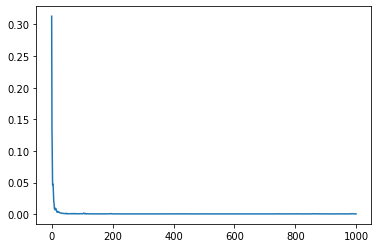

In [99]:
plt.plot(xline, losses)

In [100]:
#test
y_test_pred= lstm.forward(x_test)

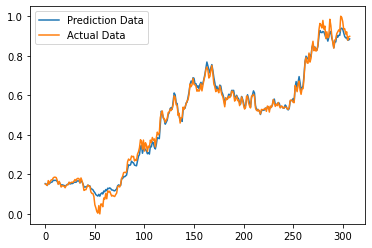

In [101]:
# training data fitting 
plt.plot(outputs.detach().numpy(), label = 'Prediction Data')
plt.plot(y_train.detach().numpy(), label='Actual Data')
plt.legend()
plt.show()

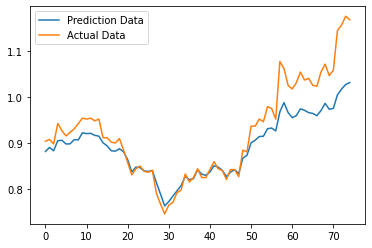

In [102]:
#test data fitting 
plt.plot(y_test_pred.detach().numpy(), label = 'Prediction Data')
plt.plot(y_test.detach().numpy(), label = 'Actual Data')
plt.legend()
plt.show()
#epochs 수를 늘릴 수록 더 잘 예측하는 것으로 들어났으나(test data에서 성능이 증가했으니 과적합은 아닌 듯), 
#급격한 지수상승 국면에선 잘 예측하지 못하는 것으로 드러남

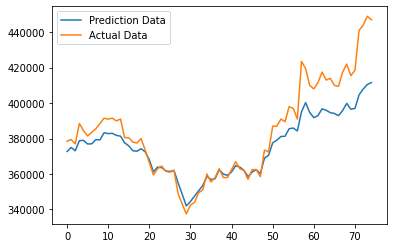

In [103]:
## Test Fitting-inverse scaling 
y_test_pred = mm.inverse_transform(y_test_pred.detach().numpy())
y_test = mm.inverse_transform(y_test.detach().numpy())
plt.plot(y_test_pred,label="Prediction Data")
plt.plot(y_test, label = "Actual Data")
plt.legend()
plt.show()

# Discussion 

- 기본적인 LSTM 모델을 이용하여 주가 예측 프로그램을 만들었음
- 상승 국면에서는 실제 결과가 예상치를 크게 웃도는 현상이 발견되었음
- 하강 국면에서는 예측을 어느정도 잘했다고 볼 수 있음 
- 무엇보다 반등지점 예측에 대한 정확도가 높아서 추가 매수 시그널로써 활용도가 있을 것으로 기대됨
- 추가로 공부할 부분: hyperparameter tuning, cross validation in time series data, etc.